In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load pre-processed data
era5 = xr.open_dataset('era5_north_america_ssrd.nc')
merra = xr.open_dataset('merra2_north_america_aot.nc4')


In [ ]:
era5

In [ ]:
merra

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                 1.524e+05
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:48:39   Log-Likelihood:            -7.0499e+07
No. Observations:             4655853   AIC:                         1.410e+08
Df Residuals:                 4655851   BIC:                         1.410e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.47e+06    811.085   1812.012      0.0

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


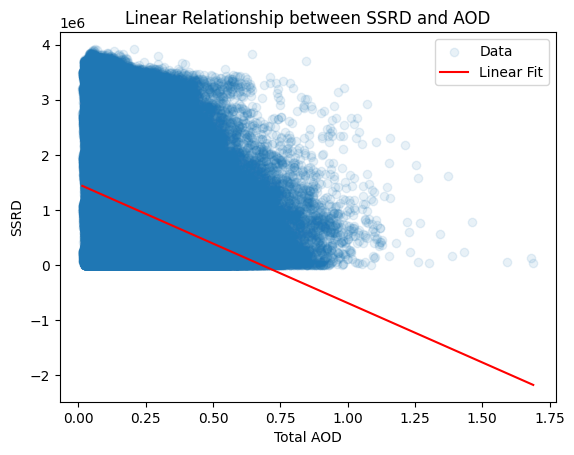

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Load data
era5 = xr.open_dataset('era5_north_america_ssrd.nc')
merra = xr.open_dataset('merra2_north_america_aot.nc4')

# 2. Rename and align
era5 = era5.rename({'valid_time': 'time'})
merra_matched = merra.interp(time=era5.time, lat=era5.lat, lon=era5.lon)

# 3. Flatten data
ssrd = era5['ssrd'].values.flatten()
aod_dust = merra_matched['DUEXTTAU'].values.flatten()
aod_bc = merra_matched['BCEXTTAU'].values.flatten()
aod_total = merra_matched['TOTEXTTAU'].values.flatten()

day_mask = (ssrd > 50)

# 6. Apply mask & drop NaN
ssrd_day = ssrd[day_mask]
aod_day = aod_total[day_mask]

# 4. Drop NaNs
mask = (~np.isnan(ssrd_day)) & (~np.isnan(aod_day))
ssrd = ssrd_day[mask]
aod_total = aod_day[mask]


# 5. Simple linear regression
X = sm.add_constant(aod_total)
model = sm.OLS(ssrd, X).fit()
print(model.summary())

# 6. Quick scatter with fitted line
plt.scatter(aod_total, ssrd, alpha=0.1, label='Data')
plt.plot(np.sort(aod_total),
         model.predict(sm.add_constant(np.sort(aod_total))),
         color='red', label='Linear Fit')
plt.xlabel('Total AOD')
plt.ylabel('SSRD')
plt.title('Linear Relationship between SSRD and AOD')
plt.legend()
plt.show()


first lets plot different graphs for each grids so there there will will as number of graphs as the grids and each graph will have plot of SSRD vs EOD, the top 10 graphs with least (error ) will be shown

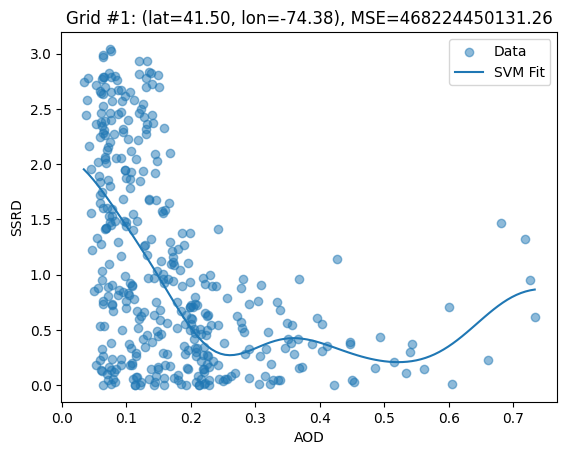

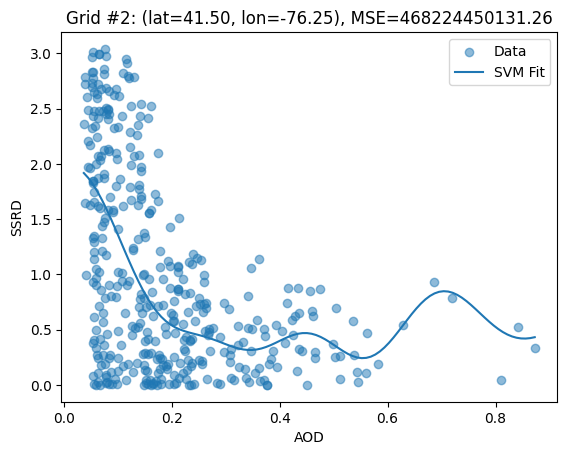

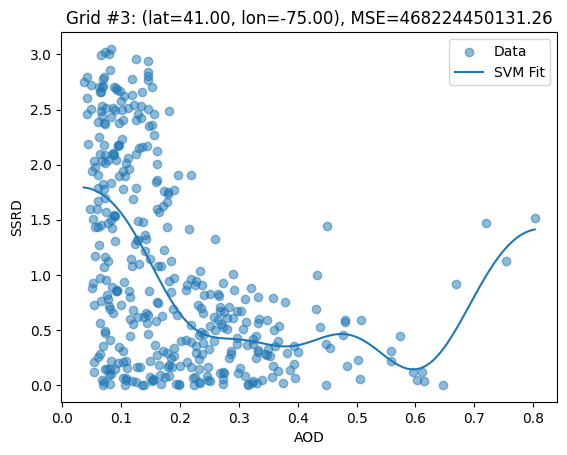

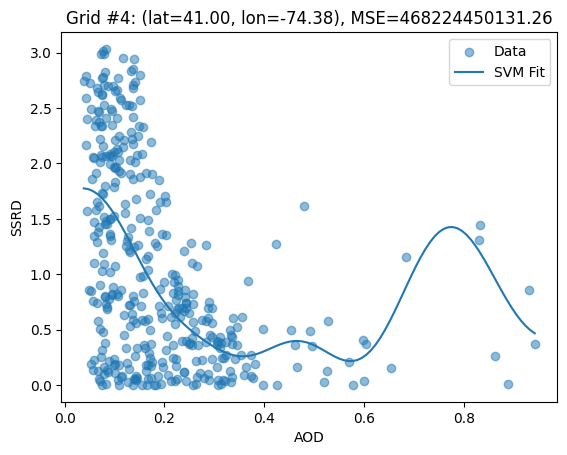

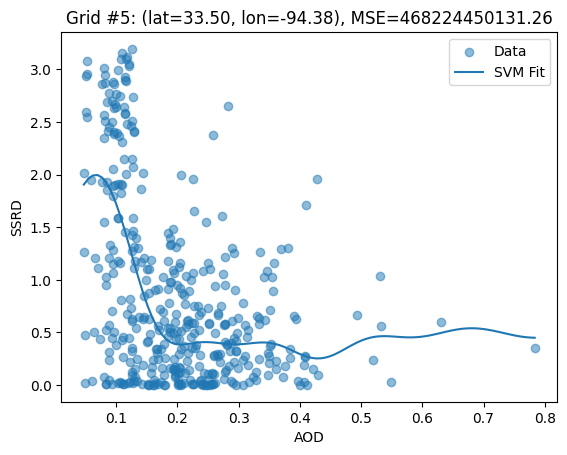

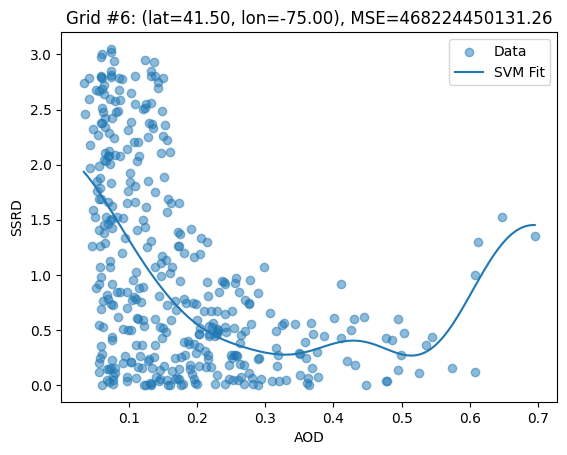

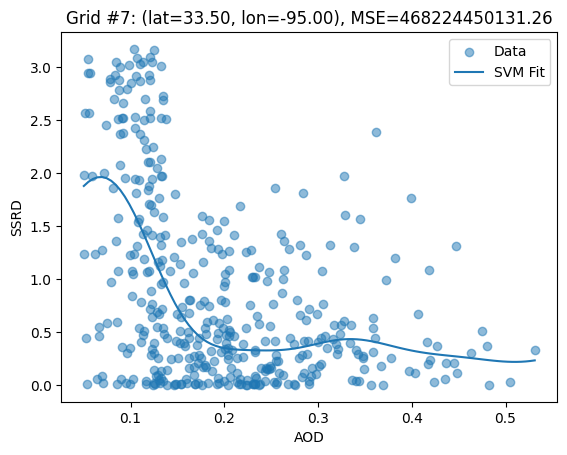

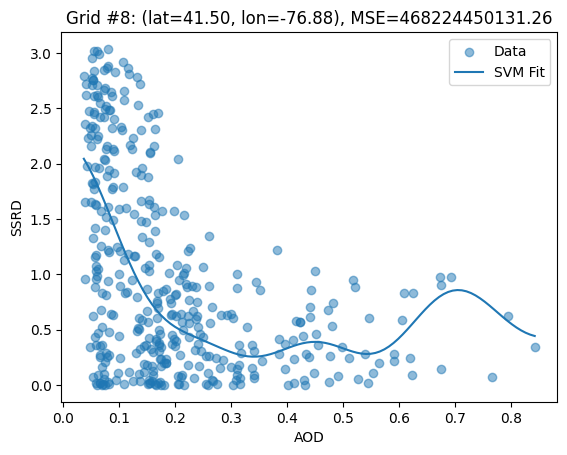

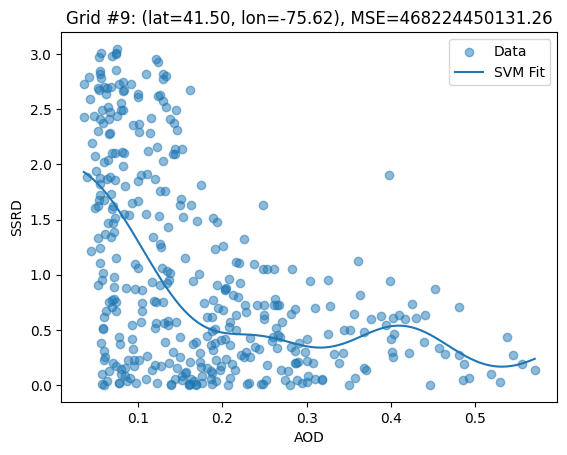

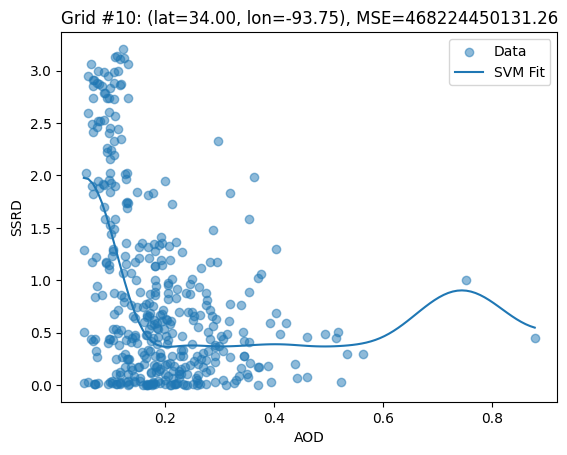

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR

# 1. Load your data
era5 = xr.open_dataset('era5_north_america_ssrd.nc')
merra = xr.open_dataset('merra2_north_america_aot.nc4')

# 2. Rename ERA5 time dimension (if needed) to match MERRA
if 'valid_time' in era5.dims or era5.coords:
    era5 = era5.rename({'valid_time': 'time'})
era5['ssrd'] = era5['ssrd'] / 1e6

# 3. Interpolate MERRA onto ERA5's coordinates for alignment


# 4. Filter out nighttime or near-zero SSRD
merra_matched = merra.interp(time=era5.time, lat=era5.lat, lon=era5.lon)

# 5. Filter out SSRD <= 100 (now in MJ/m^2), i.e., keep SSRD > 100
#    (Adjust threshold if you want; e.g., 0.1 if you want to reflect the scaled range)
mask = era5['ssrd'] > 0.001
era5_day = era5.where(mask, drop=True)
merra_day = merra_matched.where(mask, drop=True)

# 5. For demonstration, choose a smaller subset of lat/lon
#    (Otherwise, a loop over entire domain might be massive.)
#num_lats = 80
#num_lons = 200
#subset_lats = era5_day.lat.values[:num_lats]
#subset_lons = era5_day.lon.values[:num_lons]

subset_lats = era5_day.lat.values
subset_lons = era5_day.lon.values

results = []

# 6. Iterate through each grid cell in the subset
for lat in subset_lats:
    for lon in subset_lons:
        # Extract SSRD time series and AOD time series for this cell
        ssrd_ts = era5_day.sel(lat=lat, lon=lon)['ssrd'].values
        aod_ts = merra_day.sel(lat=lat, lon=lon)['TOTEXTTAU'].values


        # Drop NaNs
        valid_mask = (~np.isnan(ssrd_ts)) & (~np.isnan(aod_ts))
        ssrd_ts = ssrd_ts[valid_mask]
        aod_ts = aod_ts[valid_mask]

        # Skip if there's insufficient data
        if len(ssrd_ts) < 20:
            continue

        if np.nanstd(ssrd_ts) < 0.0001 or np.nanstd(aod_ts) < 0.03:
            continue

        # Reshape AOD for sklearn (2D input)
        X = aod_ts.reshape(-1, 1)
        y = ssrd_ts

        # 7. Train an SVM regressor
        svr = SVR(kernel='rbf')
        svr.fit(X, y)

        # 8. Make predictions and compute error (MSE)
        y_pred = svr.predict(X)
        r2 = svr.score(X, y)

        # 9. Store (lat, lon), model, MSE, and data for later
        results.append(((lat, lon), svr, r2, X, y))

# 10. Sort results by ascending MSE
results_sorted = sorted(results, key=lambda x: x[2], reverse=True)


# 11. Pick the top 10 best-performing cells
top_10 = results_sorted[:10]

# 12. Plot SSRD vs. AOD for each top cell, along with the SVM fit
for rank, (coords, svr, r2, X, y) in enumerate(top_10, start=1):
    lat, lon = coords

    plt.scatter(X, y, alpha=0.5, label='Data')

    # Build a smooth AOD sequence for the model prediction curve
    X_grid = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
    y_grid = svr.predict(X_grid)

    plt.plot(X_grid, y_grid, label='SVM Fit')
    plt.xlabel('AOD')
    plt.ylabel('SSRD')
    plt.title(f'Grid #{rank}: (lat={lat:.2f}, lon={lon:.2f}), MSE={mse:.2f}')
    plt.legend()
    plt.show()


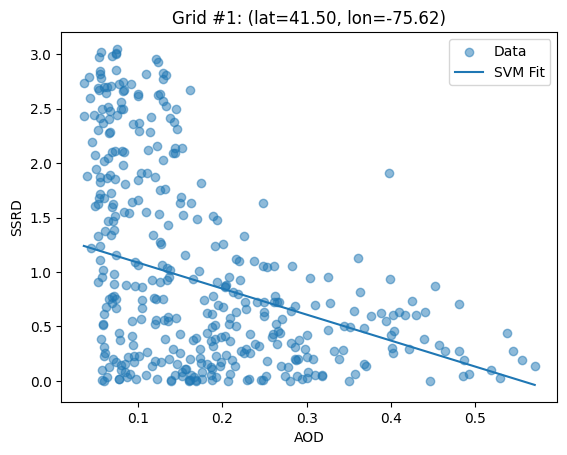

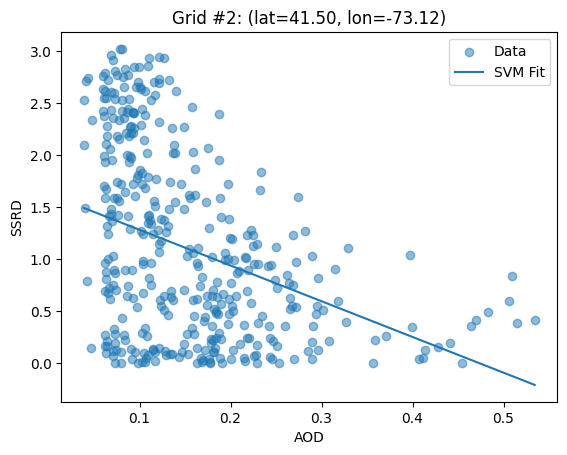

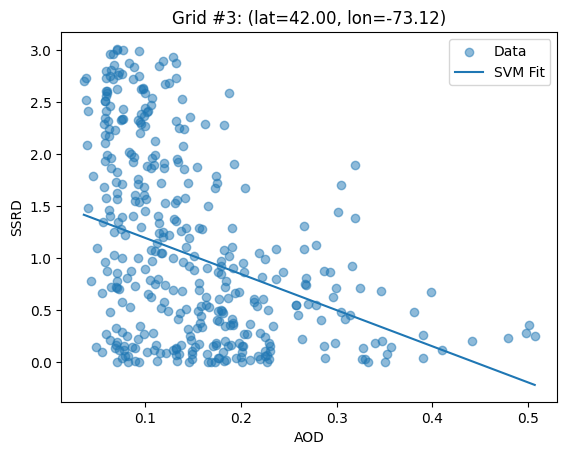

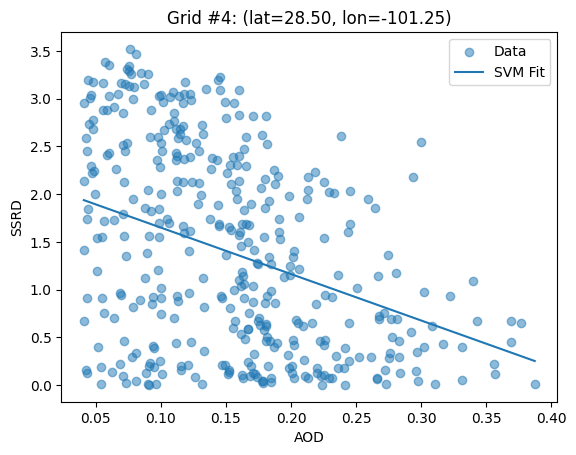

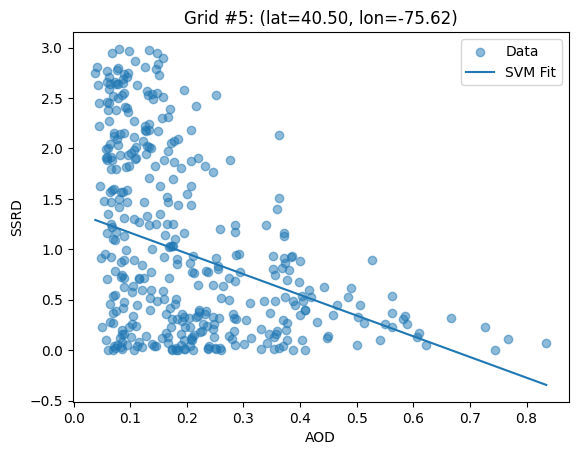

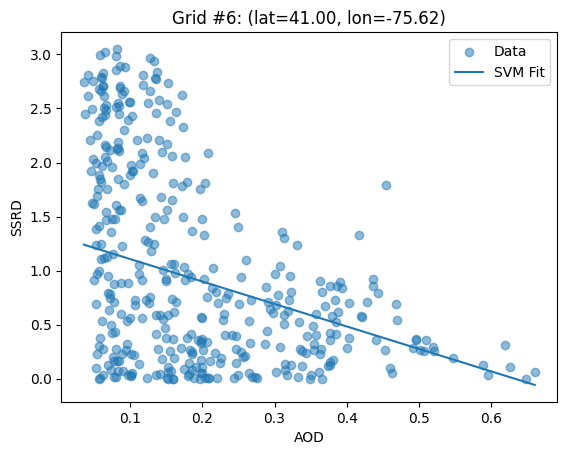

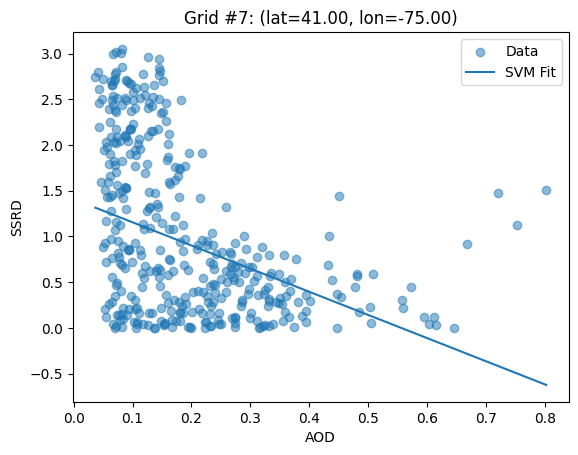

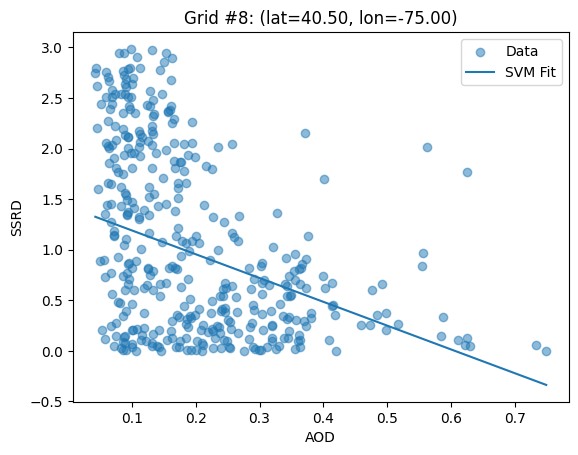

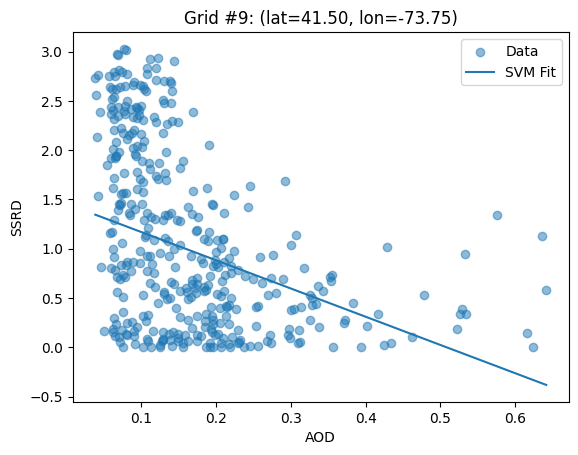

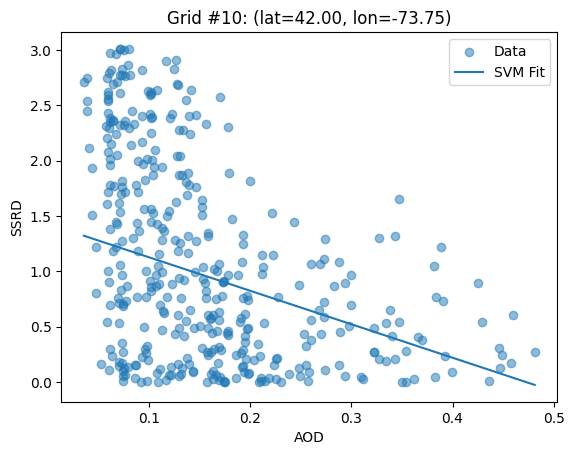

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.svm import LinearSVR

# 1. Load your data
era5 = xr.open_dataset('era5_north_america_ssrd.nc')
merra = xr.open_dataset('merra2_north_america_aot.nc4')

# 2. Rename ERA5 time dimension (if needed) to match MERRA
if 'valid_time' in era5.dims or era5.coords:
    era5 = era5.rename({'valid_time': 'time'})
era5['ssrd'] = era5['ssrd'] / 1e6

# 3. Interpolate MERRA onto ERA5's coordinates for alignment


# 4. Filter out nighttime or near-zero SSRD
merra_matched = merra.interp(time=era5.time, lat=era5.lat, lon=era5.lon)

# 5. Filter out SSRD <= 100 (now in MJ/m^2), i.e., keep SSRD > 100
#    (Adjust threshold if you want; e.g., 0.1 if you want to reflect the scaled range)
mask = era5['ssrd'] > 0.001
era5_day = era5.where(mask, drop=True)
merra_day = merra_matched.where(mask, drop=True)

# 5. For demonstration, choose a smaller subset of lat/lon
#    (Otherwise, a loop over entire domain might be massive.)
#num_lats = 80
#num_lons = 200
#subset_lats = era5_day.lat.values[:num_lats]
#subset_lons = era5_day.lon.values[:num_lons]

subset_lats = era5_day.lat.values
subset_lons = era5_day.lon.values

results = []

# 6. Iterate through each grid cell in the subset
for lat in subset_lats:
    for lon in subset_lons:
        # Extract SSRD time series and AOD time series for this cell
        ssrd_ts = era5_day.sel(lat=lat, lon=lon)['ssrd'].values
        aod_ts = merra_day.sel(lat=lat, lon=lon)['TOTEXTTAU'].values


        # Drop NaNs
        valid_mask = (~np.isnan(ssrd_ts)) & (~np.isnan(aod_ts))
        ssrd_ts = ssrd_ts[valid_mask]
        aod_ts = aod_ts[valid_mask]

        # Skip if there's insufficient data
        if len(ssrd_ts) < 20:
            continue

        if np.nanstd(ssrd_ts) < 0.0001 or np.nanstd(aod_ts) < 0.03:
            continue

        # Reshape AOD for sklearn (2D input)
        X = aod_ts.reshape(-1, 1)
        y = ssrd_ts

        # 7. Train an SVM regressor
        svr = LinearSVR(random_state=0, max_iter=10000)
        svr.fit(X, y)

        # 8. Make predictions and compute error (MSE)
        y_pred = svr.predict(X)
        r2 = svr.score(X, y)

        # 9. Store (lat, lon), model, MSE, and data for later
        results.append(((lat, lon), svr, r2, X, y))

# 10. Sort results by ascending MSE
results_sorted = sorted(results, key=lambda x: x[2], reverse=True)


# 11. Pick the top 10 best-performing cells
top_10 = results_sorted[:10]

# 12. Plot SSRD vs. AOD for each top cell, along with the SVM fit
for rank, (coords, svr, r2, X, y) in enumerate(top_10, start=1):
    lat, lon = coords

    plt.scatter(X, y, alpha=0.5, label='Data')

    # Build a smooth AOD sequence for the model prediction curve
    X_grid = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
    y_grid = svr.predict(X_grid)

    plt.plot(X_grid, y_grid, label='SVM Fit')
    plt.xlabel('AOD')
    plt.ylabel('SSRD')
    plt.title(f'Grid #{rank}: (lat={lat:.2f}, lon={lon:.2f})')
    plt.legend()
    plt.show()


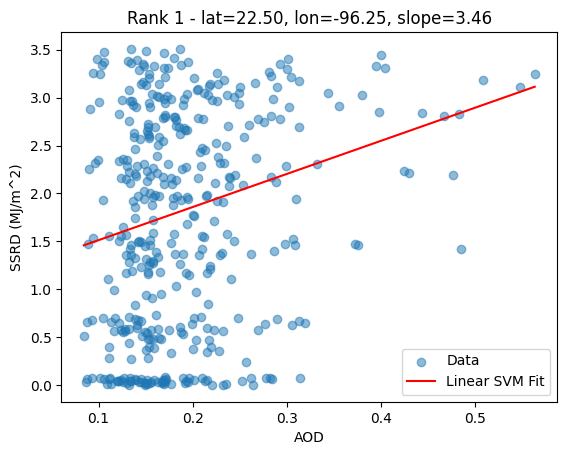

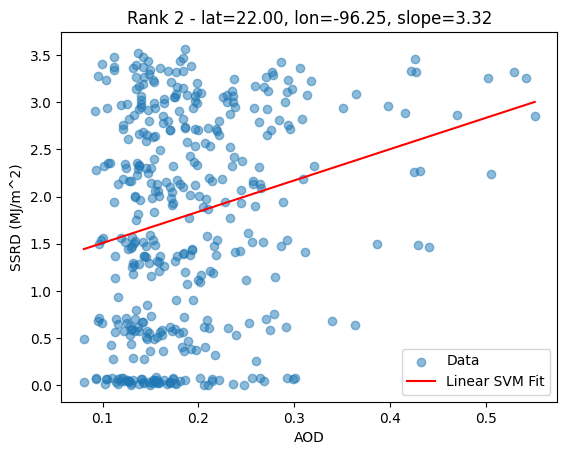

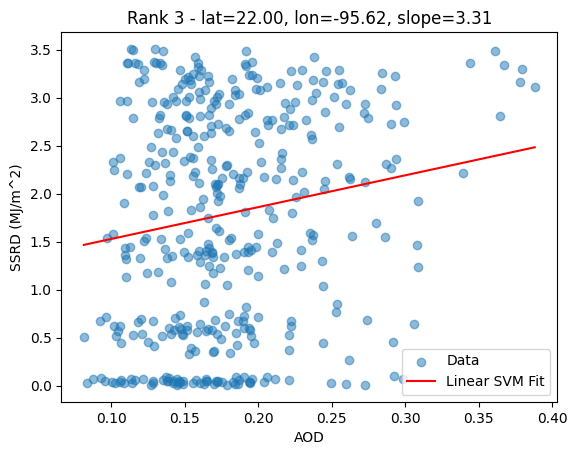

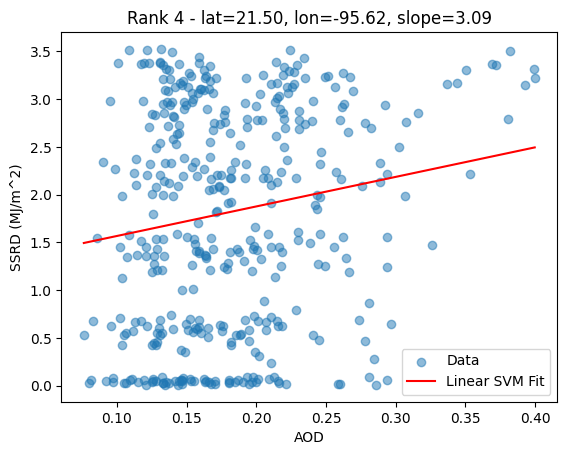

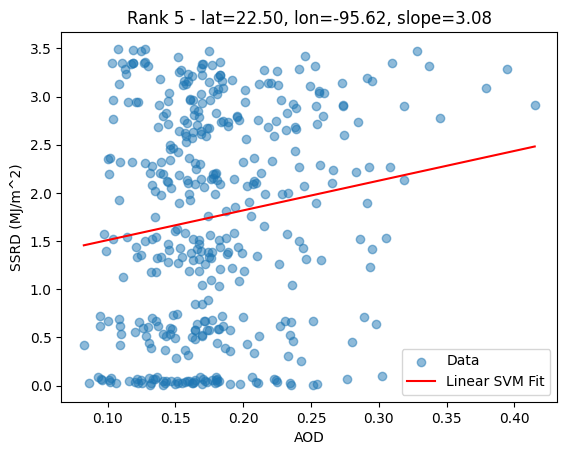

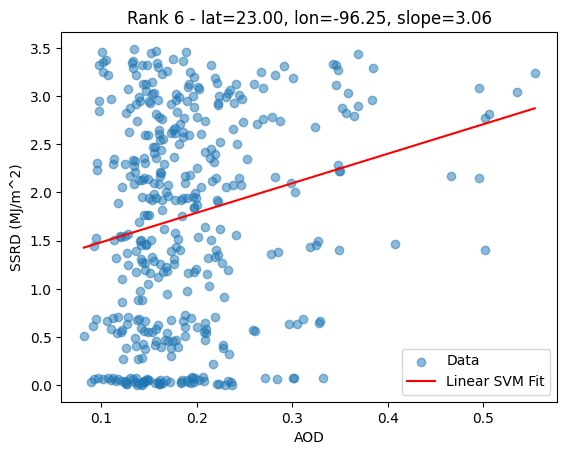

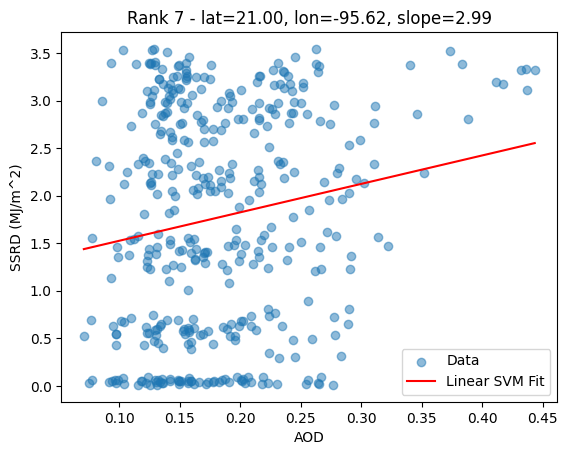

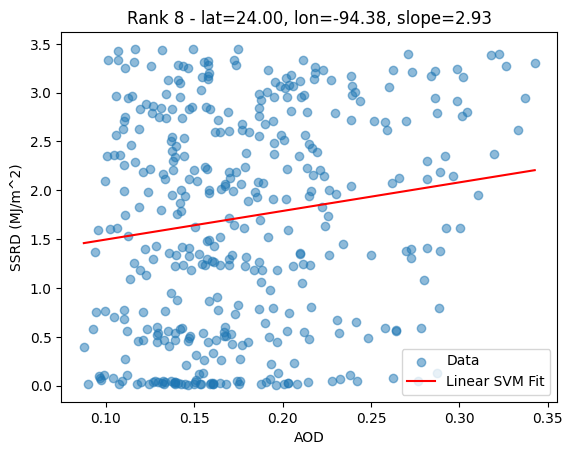

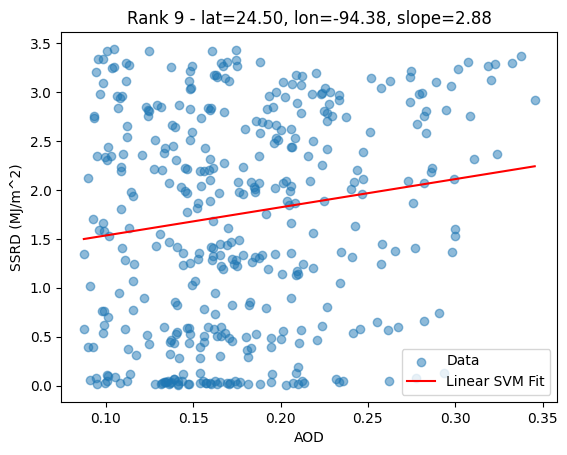

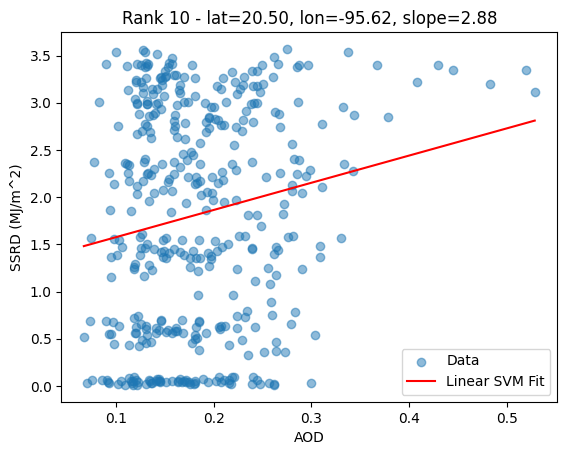

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR

# 1. Load data
era5 = xr.open_dataset('era5_north_america_ssrd.nc')
merra = xr.open_dataset('merra2_north_america_aot.nc4')

# 2. Rename time dimension if needed
if 'valid_time' in era5.dims or 'valid_time' in era5.coords:
    era5 = era5.rename({'valid_time': 'time'})

# 3. Scale/normalize the SSRD (simple approach: from J/m^2 to MJ/m^2)
#    You can also use a more formal standardization or min-max approach if desired.
era5['ssrd'] = era5['ssrd'] / 1e6

# 4. Interpolate MERRA onto ERA5's coordinates
merra_matched = merra.interp(time=era5.time, lat=era5.lat, lon=era5.lon)

# 5. Filter out SSRD <= 100 (now in MJ/m^2), i.e., keep SSRD > 100
#    (Adjust threshold if you want; e.g., 0.1 if you want to reflect the scaled range)
mask = era5['ssrd'] > 0.001
era5_day = era5.where(mask, drop=True)
merra_day = merra_matched.where(mask, drop=True)

# (Optional) pick a smaller lat/lon subset to keep this demo manageable
#num_lats = 80
#num_lons = 200
#subset_lats = era5_day.lat.values[:num_lats]
#subset_lons = era5_day.lon.values[:num_lons]

subset_lats = era5_day.lat.values
subset_lons = era5_day.lon.values

results = []

# 6. Loop over each grid cell in the subset
for lat in subset_lats:
    for lon in subset_lons:
        # Extract SSRD and AOD
        ssrd_ts = era5_day.sel(lat=lat, lon=lon)['ssrd'].values
        aod_ts = merra_day.sel(lat=lat, lon=lon)['TOTEXTTAU'].values

        # Drop NaNs
        valid_mask = (~np.isnan(ssrd_ts)) & (~np.isnan(aod_ts))
        ssrd_ts = ssrd_ts[valid_mask]
        aod_ts = aod_ts[valid_mask]

        # Skip if insufficient samples
        if len(ssrd_ts) < 20:
            continue

        # Reshape AOD for sklearn
        X = aod_ts.reshape(-1, 1)
        y = ssrd_ts

        # 7. Train a linear SVM
        svr = LinearSVR(random_state=0, max_iter=10000)
        svr.fit(X, y)

        # 8. Extract the slope (coefficient)
        slope = svr.coef_[0]
        if(slope<0):
          continue
        # Keep track of results
        # We'll rank by |slope|
        results.append(((lat, lon), slope, X, y, svr))

# 9. Sort results by the largest absolute slope
results_sorted = sorted(results, key=lambda x: abs(x[1]), reverse=True)

# 10. Select top 10 with the greatest |slope|
top_10 = results_sorted[:10]

# 11. Plot each grid cell's data + linear SVM line
for rank, (coords, slope, X, y, svr) in enumerate(top_10, start=1):
    lat, lon = coords

    # Scatter the scaled data
    plt.scatter(X, y, alpha=0.5, label='Data')

    # Build a line to visualize the SVM's linear fit
    intercept = svr.intercept_[0]
    x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_range = slope * x_range + intercept

    plt.plot(x_range, y_range, color='red', label='Linear SVM Fit')

    # Axis labels reflect the scaled SSRD and original AOD
    plt.xlabel('AOD')
    plt.ylabel('SSRD (MJ/m^2)')  # Because we divided by 1e6

    plt.title(f"Rank {rank} - lat={lat:.2f}, lon={lon:.2f}, slope={slope:.2f}")
    plt.legend()
    plt.show()


In [ ]:
import xarray as xr
import numpy as np
from sklearn.svm import LinearSVR
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
# 1. Load data
era5 = xr.open_dataset('era5_north_america_ssrd.nc')
merra = xr.open_dataset('merra2_north_america_aot.nc4')

# 2. Rename time dimension if necessary
if 'valid_time' in era5.dims or 'valid_time' in era5.coords:
    era5 = era5.rename({'valid_time': 'time'})

# 3. Simple scale of SSRD (optional) to reduce from J/m² to MJ/m²
era5['ssrd'] = era5['ssrd'] / 1e6

# 4. Interpolate MERRA onto ERA5's coordinates
merra_matched = merra.interp(time=era5.time, lat=era5.lat, lon=era5.lon)

# 5. Filter out SSRD <= 100 MJ/m²
mask = era5['ssrd'] > 0.001
era5_day = era5.where(mask, drop=True)
merra_day = merra_matched.where(mask, drop=True)

# 6. Extract full arrays of lat/lon
all_lats = era5_day.lat.values
all_lons = era5_day.lon.values

# Create an empty array to store slope at each (lat, lon)
slope_map = np.full((len(all_lats), len(all_lons)), np.nan)

# 7. Loop over lat/lon
for i, lat_val in enumerate(all_lats):
    for j, lon_val in enumerate(all_lons):

        # Extract SSRD and AOD time series for this grid cell
        ssrd_ts = era5_day.sel(lat=lat_val, lon=lon_val)['ssrd'].values
        aod_ts = merra_day.sel(lat=lat_val, lon=lon_val)['TOTEXTTAU'].values

        # Drop NaNs
        valid_mask = (~np.isnan(ssrd_ts)) & (~np.isnan(aod_ts))
        ssrd_ts = ssrd_ts[valid_mask]
        aod_ts = aod_ts[valid_mask]

        # Skip if insufficient data
        if len(ssrd_ts) < 20:
            continue

        mask = aod_ts > 0.3
        y1 = ssrd_ts[mask]
        X1 = aod_ts[mask]
        X1=X1.reshape(-1, 1)
        if len(X1) < 8:
          continue
        centroid_x = np.mean(X1)
        centroid_y = np.mean(y1)
        centroid = (centroid_x, centroid_y)
        points = np.column_stack((X1, y1))
        distances = pairwise_distances(points, np.array([centroid]).reshape(1, -1))
        distances=np.mean(distances)

        # Reshape AOD for sklearn
        X = aod_ts.reshape(-1, 1)
        y = ssrd_ts

        # Fit linear SVM
        svr = LinearSVR(random_state=0, max_iter=10000)
        svr.fit(X, y)
        y_pred = svr.predict(X)
        r2 = svr.score(X, y)
        mse=np.mean((y - y_pred) ** 2)
        data = np.column_stack((X1, y1))

        #kmeans = KMeans(n_clusters=1).fit(data)
        #inertia = kmeans.inertia_

        # Extract slope
        slope = svr.coef_[0]
        if(0.1<distances<0.65 ):
          slope_map[i, j] = slope
        # Store slope in slope_map



In [ ]:
import xarray as xr
import numpy as np
from sklearn.svm import LinearSVR
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
# 1. Load data
era5 = xr.open_dataset('era5_north_america_ssrd.nc')
merra = xr.open_dataset('merra2_north_america_aot.nc4')

# 2. Rename time dimension if necessary
if 'valid_time' in era5.dims or 'valid_time' in era5.coords:
    era5 = era5.rename({'valid_time': 'time'})

# 3. Simple scale of SSRD (optional) to reduce from J/m² to MJ/m²
era5['ssrd'] = era5['ssrd'] / 1e6

# 4. Interpolate MERRA onto ERA5's coordinates
merra_matched = merra.interp(time=era5.time, lat=era5.lat, lon=era5.lon)

# 5. Filter out SSRD <= 100 MJ/m²
mask = era5['ssrd'] > 0.001
era5_day = era5.where(mask, drop=True)
merra_day = merra_matched.where(mask, drop=True)

# 6. Extract full arrays of lat/lon
all_lats = era5_day.lat.values
all_lons = era5_day.lon.values

# Create an empty array to store slope at each (lat, lon)
slope_map = np.full((len(all_lats), len(all_lons)), np.nan)

# 7. Loop over lat/lon
for i, lat_val in enumerate(all_lats):
    for j, lon_val in enumerate(all_lons):

        # Extract SSRD and AOD time series for this grid cell
        ssrd_ts = era5_day.sel(lat=lat_val, lon=lon_val)['ssrd'].values
        aod_ts = merra_day.sel(lat=lat_val, lon=lon_val)['TOTEXTTAU'].values

        # Drop NaNs
        valid_mask = (~np.isnan(ssrd_ts)) & (~np.isnan(aod_ts))
        ssrd_ts = ssrd_ts[valid_mask]
        aod_ts = aod_ts[valid_mask]

        # Skip if insufficient data
        if len(ssrd_ts) < 20:
            continue

        mask = aod_ts > 0.25
        y1 = ssrd_ts[mask]
        X1 = aod_ts[mask]
        X1=X1.reshape(-1, 1)


        # Reshape AOD for sklearn
        X = aod_ts.reshape(-1, 1)
        y = ssrd_ts

        # Fit linear SVM
        svr = LinearSVR(random_state=0, max_iter=10000)
        svr.fit(X, y)
        y_pred = svr.predict(X)
        r2 = svr.score(X, y)
        mse=np.mean((y - y_pred) ** 2)


        #kmeans = KMeans(n_clusters=1).fit(data)
        #inertia = kmeans.inertia_

        # Extract slope
        slope = svr.coef_[0]
        #if(0.1<distances<0.65 ):
        slope_map[i, j] =slope
        # Store slope in slope_map

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 96.4 MB/s eta 0:00:00


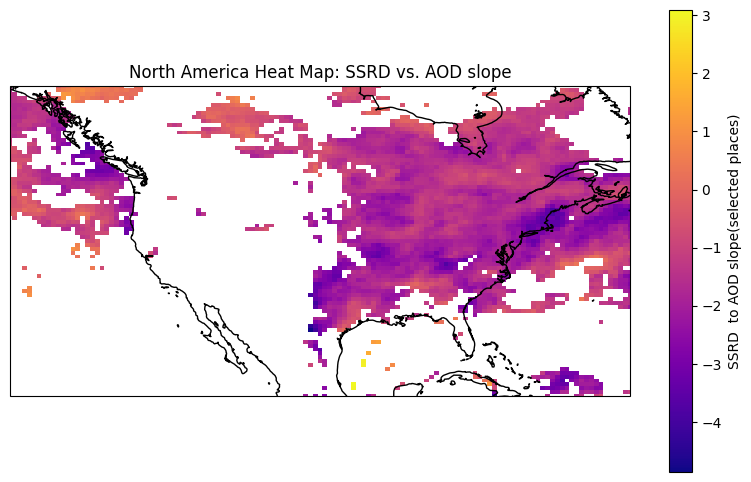

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# 1. Create a figure & define a Cartopy projection
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# 2. Optional: set map extent (approx for North America)
ax.set_extent([-140, -60, 20, 60], crs=ccrs.PlateCarree())

# 3. Plot with pcolormesh or contourf
#    all_lons, all_lats should be 1D arrays
#    slope_map is 2D with shape (len(lat), len(lon))
mesh = ax.pcolormesh(
    all_lons,
    all_lats,
    slope_map,
    transform=ccrs.PlateCarree(),
    cmap='plasma',  # or any preferred colormap
    shading='auto'
)

# 4. Add coastlines & colorbar
ax.coastlines()
plt.colorbar(mesh, ax=ax, label='SSRD  to AOD slope(selected places)')

plt.title('North America Heat Map: SSRD vs. AOD slope')
plt.show()


In [ ]:
import xarray as xr
import numpy as np
from sklearn.svm import LinearSVR
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
# 1. Load data
era5 = xr.open_dataset('era5_north_america_ssrd.nc')
merra = xr.open_dataset('merra2_north_america_aot.nc4')

# 2. Rename time dimension if necessary
if 'valid_time' in era5.dims or 'valid_time' in era5.coords:
    era5 = era5.rename({'valid_time': 'time'})

# 3. Simple scale of SSRD (optional) to reduce from J/m² to MJ/m²
era5['ssrd'] = era5['ssrd'] / 1e6

# 4. Interpolate MERRA onto ERA5's coordinates
merra_matched = merra.interp(time=era5.time, lat=era5.lat, lon=era5.lon)

# 5. Filter out SSRD <= 100 MJ/m²
mask = era5['ssrd'] > 0.001
era5_day = era5.where(mask, drop=True)
merra_day = merra_matched.where(mask, drop=True)

# 6. Extract full arrays of lat/lon
all_lats = era5_day.lat.values
all_lons = era5_day.lon.values

# Create an empty array to store slope at each (lat, lon)
slope_map = np.full((len(all_lats), len(all_lons)), np.nan)

# 7. Loop over lat/lon
for i, lat_val in enumerate(all_lats):
    for j, lon_val in enumerate(all_lons):

        # Extract SSRD and AOD time series for this grid cell
        ssrd_ts = era5_day.sel(lat=lat_val, lon=lon_val)['ssrd'].values
        aod_ts = merra_day.sel(lat=lat_val, lon=lon_val)['TOTEXTTAU'].values

        # Drop NaNs
        valid_mask = (~np.isnan(ssrd_ts)) & (~np.isnan(aod_ts))
        ssrd_ts = ssrd_ts[valid_mask]
        aod_ts = aod_ts[valid_mask]

        # Skip if insufficient data
        if len(ssrd_ts) < 20:
            continue

        mask = aod_ts > 0.25
        y1 = ssrd_ts[mask]
        X1 = aod_ts[mask]
        X1=X1.reshape(-1, 1)


        # Reshape AOD for sklearn
        X = aod_ts.reshape(-1, 1)
        y = ssrd_ts

        # Fit linear SVM
        svr = LinearSVR(random_state=0, max_iter=10000)
        svr.fit(X, y)
        y_pred = svr.predict(X)
        r2 = svr.score(X, y)
        mse=np.mean((y - y_pred) ** 2)


        #kmeans = KMeans(n_clusters=1).fit(data)
        #inertia = kmeans.inertia_

        # Extract slope
        slope = svr.coef_[0]
        #if(0.1<distances<0.65 ):
        slope_map[i, j] =slope
        # Store slope in slope_map